In [153]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm

# Set plotting style
plt.style.use("default")
params = {
    "axes.labelsize": 12, "font.size": 12, "legend.fontsize": 12,
    "xtick.labelsize": 12, "ytick.labelsize": 12, "text.usetex": False,
    "font.family": "sans-serif", "axes.spines.top": False, "axes.spines.right": False,
    "grid.color": "grey", "axes.grid": True, "grid.alpha": 0.5, "grid.linestyle": ":",
}
plt.rcParams.update(params)

In [154]:
# --------------------------
# User Settings and Parameters
# --------------------------
stock_ticker = 'CASY'  # Change to your desired ticker
market_index = 'SPY'   # For beta calculation
start_date = "2006-01-01"
end_date   = "2023-12-31"

# List of factors to include in the regression.
# You can customize this list to include a subset of factors.
selected_factors = ['Mkt-RF', 'SMB', 'HML', 'Beta', 'Volatility', 'Momentum', 'Reversal', 'Value', 'Growth']

In [155]:
# --------------------------
# Step 1: Download Stock and Market Data
# --------------------------
# Download historical data for the selected stock and the market index
stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
market_data = yf.download(market_index, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [156]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,CASY,CASY,CASY,CASY,CASY
Date,,,,,
2006-01-03,21.440409,21.658504,20.660300,20.895172,473300
2006-01-04,21.138437,21.675286,21.138437,21.608180,397300
2006-01-05,21.742392,21.910158,21.054554,21.121660,501100
2006-01-06,21.876598,22.178576,21.532680,21.977258,204700
2006-01-09,21.591412,22.086320,21.465588,21.960496,273000
...,...,...,...,...,...
2023-12-22,271.996521,273.973331,271.191888,272.542866,108300
2023-12-26,270.893890,271.976668,269.801170,271.211748,139600


In [157]:
market_data

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2006-01-03,88.490387,88.699916,86.877028,87.435770,73256700
2006-01-04,88.909393,89.042090,88.490335,88.602085,51899600
2006-01-05,88.965302,89.111970,88.616089,88.804667,47307500
2006-01-06,89.705605,89.803384,88.951305,89.412268,62885900
2006-01-09,89.936119,90.138657,89.663734,89.691666,43527400
...,...,...,...,...,...
2023-12-22,467.651306,469.359407,465.726021,467.858638,67126600
2023-12-26,469.625977,470.544191,467.986997,468.066000,55387000


In [158]:
# --------------------------
# Step 2: Resample to Monthly and Calculate Returns
# --------------------------
# Resample stock and market data to month-end
stock_monthly = stock_data["Close"].resample("ME").ffill()
market_monthly = market_data["Close"].resample("ME").ffill()

# Convert the DateTime index to a PeriodIndex (monthly) for consistency with factor data
stock_monthly.index = stock_monthly.index.to_period("M")
market_monthly.index = market_monthly.index.to_period("M")

In [159]:
stock_monthly

Ticker,CASY
Date,
2006-01,21.385744
2006-02,22.041182
2006-03,19.217773
2006-04,18.013182
2006-05,18.855310
...,...
2023-08,242.405472
2023-09,269.293152
2023-10,270.109100


In [161]:
# Calculate monthly returns in percentage (e.g., 2.5 for 2.5%)
stock_monthly = pd.DataFrame(stock_monthly)
stock_monthly.rename(columns={"CASY": "Price"}, inplace=True) # Make sure to change this with each stock
stock_monthly["Return"] = stock_monthly["Price"].pct_change() * 100
stock_monthly.dropna(inplace=True)

In [162]:
stock_monthly

Ticker,Price,Return
Date,,
2006-02,22.041182,3.064834
2006-03,19.217773,-12.809695
2006-04,18.013182,-6.268113
2006-05,18.855310,4.675069
2006-06,21.061686,11.701611
...,...,...
2023-08,242.405472,-3.265254
2023-09,269.293152,11.092027
2023-10,270.109100,0.302996


In [163]:
market_monthly = pd.DataFrame(market_monthly)
market_monthly.rename(columns={"SPY": "Price"}, inplace=True)
market_monthly["Return"] = market_monthly["Price"].pct_change() * 100
market_monthly.dropna(inplace=True)

# Rename the market return column for clarity
market_monthly.rename(columns={"Return": "SPY_Return"}, inplace=True)

In [164]:
market_monthly

Ticker,Price,SPY_Return
Date,,
2006-02,89.558937,0.572506
2006-03,91.037025,1.650409
2006-04,92.186989,1.263182
2006-05,89.410240,-3.012083
2006-06,89.643448,0.260829
...,...,...
2023-08,441.294281,-1.625208
2023-09,420.361725,-4.743446
2023-10,411.236267,-2.170858


In [165]:
# --------------------------
# Step 3: Load Fama-French Factor Data
# --------------------------
# Load the Fama-French three factors CSV file
ff_factors = pd.read_csv("F-F_Research_Data_Factors-monthly.CSV", index_col=0)
ff_factors.index.name = "Date"
# Convert index to datetime then to PeriodIndex (monthly)
ff_factors.index = pd.to_datetime(ff_factors.index, format="%Y%m")
ff_factors.index = ff_factors.index.to_period("M")

# Keep only the dates that match the stock monthly returns
ff_factors = ff_factors[ff_factors.index.isin(stock_monthly.index)].copy()

In [166]:
# --------------------------
# Step 4: Merge DataFrames
# --------------------------
# Merge stock returns and market returns
df = pd.merge(stock_monthly[['Return']], market_monthly[['SPY_Return']], left_index=True, right_index=True, how="inner")
# Merge with Fama-French factors
df = pd.merge(df, ff_factors, left_index=True, right_index=True, how="inner")

# Calculate Excess Return: Stock Return minus RF (risk-free rate from Fama-French data)
df["Excess_Return"] = df["Return"] - df["RF"]

In [167]:
# --------------------------
# Step 5: Compute Additional Factors
# --------------------------

# 5a. Beta Factor: Rolling 36-month beta using SPY returns
# Beta = Cov(Stock, SPY) / Var(SPY)
df["Beta"] = df["Return"].rolling(window=36).cov(df["SPY_Return"]) / df["SPY_Return"].rolling(window=36).var()

# 5b. Volatility Factor: 36-month rolling standard deviation (in monthly terms)
df["Volatility"] = df["Return"].rolling(window=36).std()

# 5c. Momentum Factor: Cumulative return from month t-12 to t-2 (skip the most recent month)
# To do this, shift returns by 1 so that for month t we use t-1 as the latest available, then apply a rolling window of 11 months.
def cumulative_return(x):
    # Convert percentage returns to decimals, compute product, then convert back to percentage
    return (np.prod(1 + x/100) - 1) * 100

df["Momentum"] = df["Return"].shift(1).rolling(window=11).apply(cumulative_return, raw=True)

# 5d. Reversal Factor: Previous month's return
df["Reversal"] = df["Return"].shift(1)

In [168]:
# --------------------------
# Step 6: Fetch Current Fundamentals for Value and Growth
# --------------------------
ticker_obj = yf.Ticker(stock_ticker)
info = ticker_obj.info

# For Value, use 'priceToBook'
value_factor = info.get("priceToBook", np.nan)
# For Growth, use 'earningsQuarterlyGrowth'
growth_factor = info.get("earningsQuarterlyGrowth", np.nan)

# Add these as constant factors (same value for all dates)
df["Value"] = value_factor
df["Growth"] = growth_factor

In [169]:
# --------------------------
# Step 7: Drop Rows with Missing Data
# --------------------------
# Because of rolling window calculations and shifting, drop the initial months with NaNs.
df.dropna(inplace=True)

In [170]:
# --------------------------
# Step 8: Prepare Regression Inputs
# --------------------------
# The dependent variable is the Excess Return
y = df["Excess_Return"]

# The independent variables are those selected by the user
# Ensure that only the desired factors (if available in df) are used
available_factors = df.columns.intersection(selected_factors)
X = df[available_factors]

# Add constant term
X = sm.add_constant(X)

In [171]:
# --------------------------
# Step 9: Run the Regression
# --------------------------
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     9.049
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           1.72e-09
Time:                        22:13:15   Log-Likelihood:                -569.18
No. Observations:                 180   AIC:                             1154.
Df Residuals:                     172   BIC:                             1180.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6509      0.105      6.202      0.0

In [179]:
# --------------------------
# Step 10: Plot Regression Coefficients
# --------------------------
# Extract coefficients and confidence intervals (skipping the constant)
factors = model.params.index  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

# Prepare a DataFrame for plotting
ols_data = pd.DataFrame({
    "Factor": factors,
    "Coefficient": coefficients,
    "Confidence_Lower": confidence_intervals[0],
    "Confidence_Upper": confidence_intervals[1],
})

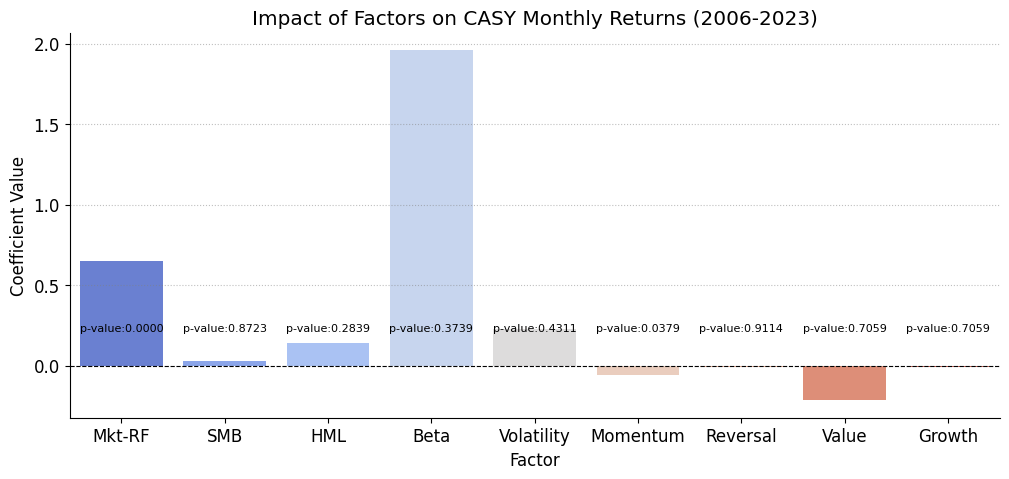

In [180]:
# Plot using Seaborn barplot with hue assigned and legend removed
plt.figure(figsize=(12, 5))
ax = sns.barplot(x="Factor", y="Coefficient", data=ols_data, capsize=0.2, hue="Factor", palette="coolwarm")

# Add the p-value for each factor to the plot
for i, row in ols_data.iterrows():
    plt.text(
        i,
        0.2,
        f"p-value:{model.pvalues[row['Factor']]:.4f}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.title("Impact of Factors on CASY Monthly Returns (2006-2023)")
plt.xlabel("Factor")
plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.show()